In [2]:
# import libraries 
import pandas as pd
from sklearn.cluster import KMeans
from sklearn_extra.cluster import CLARA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import matplotlib.patches as mpatches
import seaborn as sns
import skfuzzy as fuzz
import pickle
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [3]:
my_colors = ['#88292F', '#697268', '#12355B', '#D7816A', '#e8da6f', '#c33b43', 
               '#9DBF9E', '#64a0e0', '#343934', '#280003','#cd5a61', '#913d27', 
               '#F46036', '#248232',  '#bea602', '#0a6682', '#646536', '#624763', '#2F1847', 
               '#FF7B9C', '#66A182', '#94849B', '#ACD8AA', '#F48498', '#B30089']
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', my_colors)

In [4]:
pca_df = pd.read_csv('pca_df.csv')
df_subset = pd.read_csv('df_subset.csv')

In [5]:
# Define silhouette scoring function
def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    return silhouette_score(X, labels)

# Partition Clustering

## K-Means

### Find the optimal k number by the elbow method

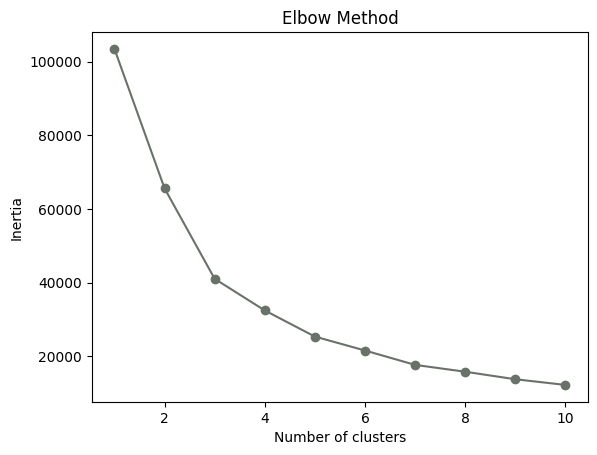

In [5]:
inertia = []

for k in range(1,11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(pca_df)
    inertia.append(kmeans.inertia_)

plt.plot(range(1,11), inertia, marker = 'o', c = '#697268')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

k = 4, because is where inertia starts decreasing in an almost linear rate

In [6]:
# Define the parameter grid
param_grid = {
    'n_clusters': [2, 3, 4, 5, 10],
}

k_means_clust = KMeans(random_state=1)

# Initialize GridSearchCV
grid_search = GridSearchCV(k_means_clust, param_grid, scoring=silhouette_scorer, cv=2, verbose=2, n_jobs=-1)

# Perform grid search
grid_search.fit(pca_df)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[CV] END .......................................n_clusters=2; total time=  18.7s
[CV] END .......................................n_clusters=4; total time=  18.7s
[CV] END .......................................n_clusters=5; total time=  18.6s
[CV] END .......................................n_clusters=3; total time=  19.5s
[CV] END .......................................n_clusters=3; total time=  19.6s
[CV] END .......................................n_clusters=2; total time=  19.2s
[CV] END .......................................n_clusters=5; total time=  19.4s
[CV] END .......................................n_clusters=4; total time=  19.8s
[CV] END ......................................n_clusters=10; total time=   5.5s
[CV] END ......................................n_clusters=10; total time=   5.5s


GridSearchCV(cv=2, estimator=KMeans(random_state=1), n_jobs=-1,
             param_grid={'n_clusters': [2, 3, 4, 5, 10]},
             scoring=<function silhouette_scorer at 0x7fb0b6444040>, verbose=2)

In [7]:
# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Get the best silhouette score
best_score = grid_search.best_score_
print("Best Silhouette Score:", best_score)

Best Parameters: {'n_clusters': 3}
Best Silhouette Score: 0.386046990831055


In [54]:
pca_df = pca_df[['PC1', 'PC2']]

also according to NbClust, 3 is the best number of clusters

In [50]:
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(pca_df)

# Get cluster labels
cluster_labels = kmeans.labels_

In [51]:
with open('results/partitional_opt/kmeans_model.pickle', 'wb') as f:
    pickle.dump(kmeans, f)

In [10]:
with open('results/partitional_opt/kmeans_model.pickle', 'rb') as f:
    kmeans = pickle.load(f)

In [52]:
cluster_labels = kmeans.labels_

In [55]:
pca_df['cluster'] = cluster_labels
pca_df['asset_id'] = df_subset['asset_id']

In [56]:
pca_df.to_csv('results/partitional_opt/csv_labels_raw/kmeans.csv', index=False)

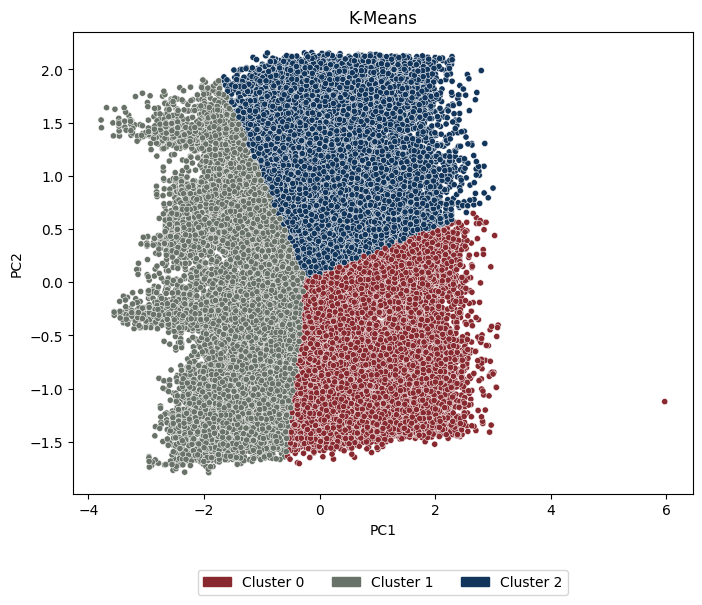

In [57]:
n_clusters = len(pca_df['cluster'].unique())
pallete = sns.color_palette(my_colors, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster', palette=pallete, s=20)
plt.title('K-Means')
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(cluster_labels)],
            loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.show()

In [58]:
most_frequent_clusters = pca_df.groupby('asset_id')['cluster'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
pca_df = pca_df.drop(columns='cluster')

pca_df = pd.merge(pca_df, most_frequent_clusters, on='asset_id', how='left')

pca_df.head()

,PC1,PC2,asset_id,cluster
0,-0.828210,-0.636266,11,2
1,0.449997,0.756881,11,2
2,1.051556,1.451060,11,2
3,-0.911238,-0.388945,11,2
4,1.337903,1.479679,11,2


In [59]:
pca_df.to_csv('results/partitional_opt/labels_most_common/k_means.csv', index = False)

In [60]:
# Group by asset_id and cluster, and select one representative point for each cluster
representative_points = pca_df.groupby(['asset_id']).first().reset_index()
representative_points.head()

,asset_id,PC1,PC2,cluster
0,11,-0.828210,-0.636266,2
1,12,0.251166,0.669049,2
2,13,-1.229941,-0.226747,1
3,14,-0.713823,1.031153,1
4,15,-0.987418,1.580407,2


In [61]:
assets_clusters = representative_points.groupby('cluster')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [5, 10, 12, 13, 18, 20, 22, 27, 28, 32, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 54, 56, 60, 61, 62, 65, 68, 69, 70]
Cluster 1: [2, 3, 6, 7, 8, 46, 50, 51, 52]
Cluster 2: [0, 1, 4, 9, 11, 14, 15, 16, 17, 19, 21, 23, 24, 25, 26, 29, 30, 31, 33, 34, 45, 47, 48, 49, 53, 55, 57, 58, 59, 63, 64, 66, 67]


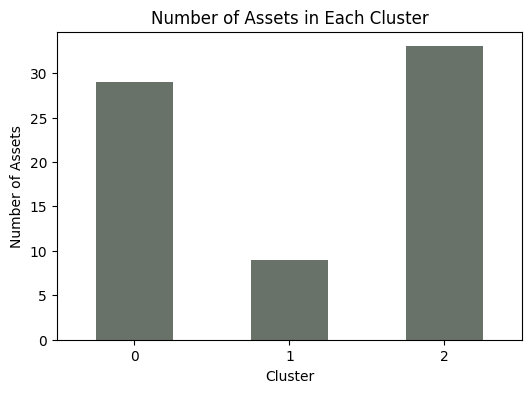

In [62]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [63]:
pca_df = pca_df.loc[:,:'PC2']
pca_df.head()

,PC1,PC2
0,-0.828210,-0.636266
1,0.449997,0.756881
2,1.051556,1.451060
3,-0.911238,-0.388945
4,1.337903,1.479679


## K-Medoids (clara)

In [21]:
# # Define the parameter grid
# param_grid = {
#     'n_clusters': [2, 3, 4, 5, 10],
# }

# k_medoids_clust = CLARA(random_state=1)

# # Initialize GridSearchCV
# grid_search = GridSearchCV(k_medoids_clust, param_grid, scoring=silhouette_scorer, cv=2, verbose=2, n_jobs=-1)

# # Perform grid search
# grid_search.fit(pca_df)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[CV] END .......................................n_clusters=4; total time=  17.5s
[CV] END .......................................n_clusters=4; total time=  18.2s
[CV] END .......................................n_clusters=5; total time=  18.4s
[CV] END .......................................n_clusters=2; total time=  18.7s
[CV] END .......................................n_clusters=3; total time=  18.8s
[CV] END .......................................n_clusters=2; total time=  19.0s
[CV] END .......................................n_clusters=3; total time=  19.0s
[CV] END .......................................n_clusters=5; total time=  19.6s
[CV] END ......................................n_clusters=10; total time=   5.9s
[CV] END ......................................n_clusters=10; total time=   5.3s


GridSearchCV(cv=2, estimator=CLARA(random_state=1), n_jobs=-1,
             param_grid={'n_clusters': [2, 3, 4, 5, 10]},
             scoring=<function silhouette_scorer at 0x7fb0b6444040>, verbose=2)

In [22]:
# # Get the best parameters
# best_params = grid_search.best_params_
# print("Best Parameters:", best_params)

# # Get the best silhouette score
# best_score = grid_search.best_score_
# print("Best Silhouette Score:", best_score)

Best Parameters: {'n_clusters': 3}
Best Silhouette Score: 0.3731650940846807


In [23]:
# pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_clusters,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,0.027112,0.001007,18.848370,0.161653,2,{'n_clusters': 2},0.342106,0.311626,0.326866,0.015240,3
1,0.044160,0.002543,18.878362,0.081891,3,{'n_clusters': 3},0.382871,0.363459,0.373165,0.009706,1
2,0.197337,0.164982,17.658322,0.154945,4,{'n_clusters': 4},0.344405,0.355518,0.349961,0.005556,2
3,0.109978,0.070974,18.887574,0.657421,5,{'n_clusters': 5},0.323178,0.315095,0.319136,0.004042,5
4,0.098876,0.004124,5.517143,0.319321,10,{'n_clusters': 10},0.310806,0.327472,0.319139,0.008333,4


In [64]:
# pca_df = pca_df[['PC1', 'PC2']]

according to the NbClust, 4 is the optimal number of clusters

In [6]:
clara = CLARA(n_clusters=4, random_state=1)
clara.fit(pca_df)
labels = clara.predict(pca_df)

In [7]:
with open('results/partitional_opt/clara.pickle', 'wb') as f:
    pickle.dump(clara, f)

In [8]:
pca_df['cluster_label'] = labels
pca_df['asset_id'] = df_subset['asset_id']

In [9]:
pca_df.to_csv('results/partitional_opt/csv_labels_raw/clara.csv', index=False)

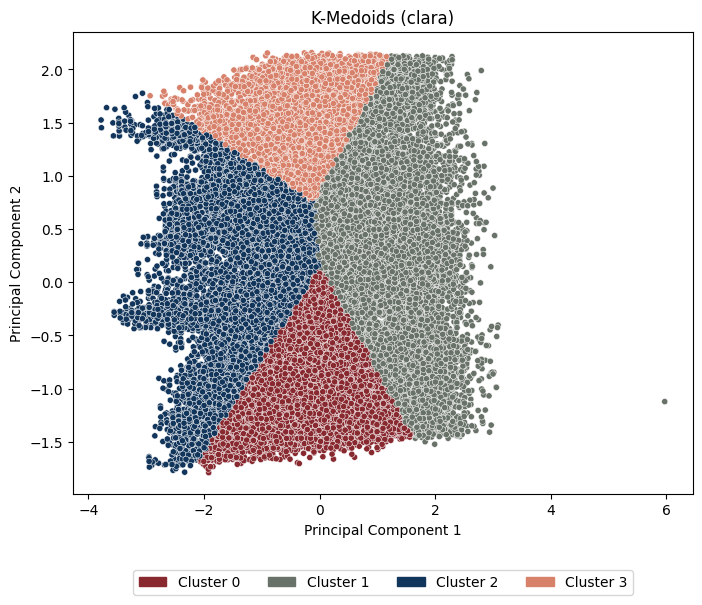

In [10]:
n_clusters = len(pca_df['cluster_label'].unique())
pallete = sns.color_palette(my_colors, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
plt.title('K-Medoids (clara)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(labels)],
            loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.show()

In [11]:
pca_df['asset_id'] = df_subset['asset_id']

most_frequent_clusters = pca_df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
pca_df = pca_df.drop(columns='cluster_label')

pca_df = pd.merge(pca_df, most_frequent_clusters, on='asset_id', how='left')

pca_df.head()

,PC1,PC2,asset_id,cluster_label
0,-0.828210,-0.636266,11,1
1,0.449997,0.756881,11,1
2,1.051556,1.451060,11,1
3,-0.911238,-0.388945,11,1
4,1.337903,1.479679,11,1


In [12]:
pca_df.to_csv('results/partitional_opt/labels_most_common/k_medoids_clara.csv', index=False)

In [13]:
# Group by asset_id and cluster, and select one representative point for each cluster
representative_points = pca_df.groupby(['asset_id']).first().reset_index()
representative_points.head()

,asset_id,PC1,PC2,cluster_label
0,11,-0.828210,-0.636266,1
1,12,0.251166,0.669049,2
2,13,-1.229941,-0.226747,2
3,14,-0.713823,1.031153,2
4,15,-0.987418,1.580407,2


In [14]:
assets_clusters = representative_points.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [5, 9, 10, 12, 14, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 49, 53, 54, 65, 68, 69, 70]
Cluster 1: [0, 11, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 66, 67]
Cluster 2: [1, 2, 3, 4, 6, 7, 8, 45, 47, 48, 50, 51, 52]


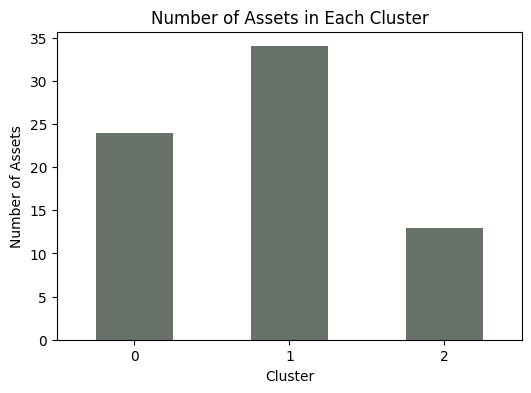

In [15]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [16]:
pca_df = pca_df.loc[:,:'PC2']

### Fuzzy C-Means

In [77]:
num_clusters = [2,3,5,10]
fuzziness_values = [0.5, 1.5, 2, 2.5]

best_combination = {}
best_silhouette = 0

for cluster in num_clusters:
    for fuzziness in fuzziness_values:
        print(f'Testing {cluster} clusters and {fuzziness} fuzziness')
        cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
            pca_df.T, cluster, fuzziness, error=0.005, maxiter=1000, init=None)
        
        cluster_membership = u.T

        assigned_clusters = np.argmax(cluster_membership, axis=1)

        sil_score = silhouette_score(pca_df[['PC1', 'PC2']], assigned_clusters)

        if sil_score > best_silhouette:
            print(f'Found a better silhouette score: {sil_score}')
            best_silhouette = sil_score
            best_combination = {'num_cluster':cluster,
                                'fuzziness': fuzziness}

print(f'The best silhouette score was {best_silhouette}\n with the parameters: \n {best_combination}')


Testing 2 clusters and 0.5 fuzziness
Found a better silhouette score: 0.3243365405626929
Testing 2 clusters and 1.5 fuzziness
Found a better silhouette score: 0.3296512320549764
Testing 2 clusters and 2 fuzziness
Testing 2 clusters and 2.5 fuzziness
Testing 3 clusters and 0.5 fuzziness
Testing 3 clusters and 1.5 fuzziness
Found a better silhouette score: 0.3821743319320436
Testing 3 clusters and 2 fuzziness
Testing 3 clusters and 2.5 fuzziness
Testing 5 clusters and 0.5 fuzziness
Testing 5 clusters and 1.5 fuzziness
Testing 5 clusters and 2 fuzziness
Testing 5 clusters and 2.5 fuzziness
Testing 10 clusters and 0.5 fuzziness
Testing 10 clusters and 1.5 fuzziness
Testing 10 clusters and 2 fuzziness
Testing 10 clusters and 2.5 fuzziness
The best silhouette score was 0.3821743319320436
 with the parameters: 
 {'num_cluster': 3, 'fuzziness': 1.5}


In [79]:
# Define parameters
num_clusters = 3
fuzziness = 1.5 

# Apply Fuzzy C-means clustering
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    pca_df.T, num_clusters, fuzziness, error=0.005, maxiter=1000, init=None)

# Extract cluster centroids
cluster_centroids = cntr.T

# Extract cluster membership probabilities
cluster_membership = u.T

# Assign data points to clusters based on membership probabilities
assigned_clusters = np.argmax(cluster_membership, axis=1)

In [80]:
data = {
    "cntr": cntr,
    "u": u,
    "u0": u0,
    "d": d,
    "jm": jm,
    "p": p,
    "fpc": fpc
}

# Open the file in write binary mode
with open('results/partitional_opt/fuzzy_c_means.pickle', "wb") as f:
    # Use pickle to dump the data dictionary into the file
    pickle.dump(data, f)

In [81]:
pca_df['cluster'] = assigned_clusters
pca_df['asset_id'] = df_subset['asset_id']

In [82]:
pca_df.to_csv('results/partitional_opt/csv_labels_raw/fuzzy_c_means.csv', index = False)

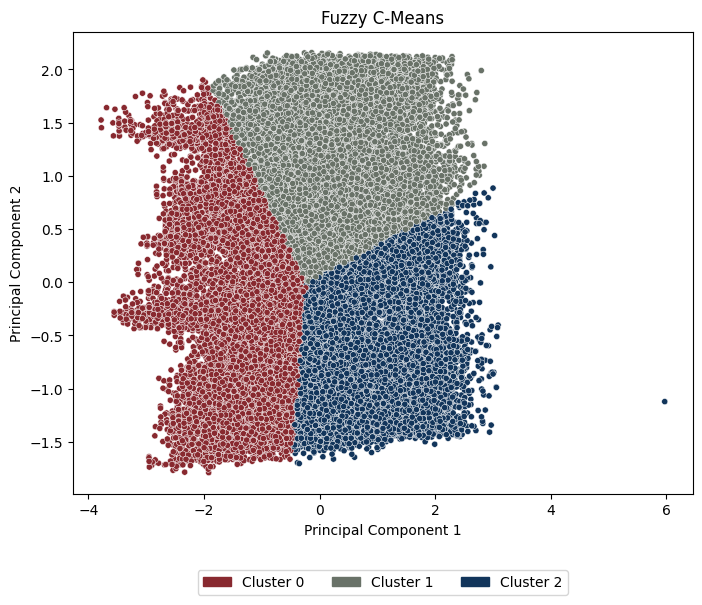

In [83]:
n_clusters = len(pca_df['cluster'].unique())
pallete = sns.color_palette(my_colors, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster', palette=pallete, s=20)
plt.title('Fuzzy C-Means')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(assigned_clusters)],
            loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.show()

In [84]:
most_frequent_clusters = pca_df.groupby('asset_id')['cluster'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
pca_df = pca_df.drop(columns='cluster')

pca_df = pd.merge(pca_df, most_frequent_clusters, on='asset_id', how='left')

In [85]:
pca_df.to_csv('results/partitional_opt/labels_most_common/fuzzy_c_means.csv', index = False)

In [86]:
# Group by asset_id and cluster, and select one representative point for each cluster
representative_points = pca_df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,PC1,PC2,cluster
0,11,-0.828210,-0.636266,1
1,12,0.251166,0.669049,1
2,13,-1.229941,-0.226747,0
3,14,-0.713823,1.031153,0
4,15,-0.987418,1.580407,1
...,...,...,...,...
66,414,-0.870138,0.643293,1
67,415,-0.623235,1.262525,1
68,510,-1.782868,-0.200945,2
69,511,-0.132724,-1.307785,2


In [87]:
assets_clusters = pca_df.groupby('asset_id')['cluster'].agg(lambda x: np.bincount(x).argmax())

# Print assets in each cluster
for cluster, assets in assets_clusters.groupby(assets_clusters):
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [13, 14, 17, 18, 19, 111, 115, 117]
Cluster 1: [11, 12, 15, 21, 22, 23, 26, 27, 28, 29, 32, 34, 36, 37, 38, 39, 41, 42, 43, 45, 47, 48, 49, 110, 112, 113, 114, 311, 313, 314, 315, 411, 412, 414, 415]
Cluster 2: [16, 24, 25, 31, 33, 35, 44, 46, 51, 52, 53, 54, 55, 56, 57, 58, 59, 116, 210, 310, 312, 316, 317, 410, 413, 510, 511, 512]


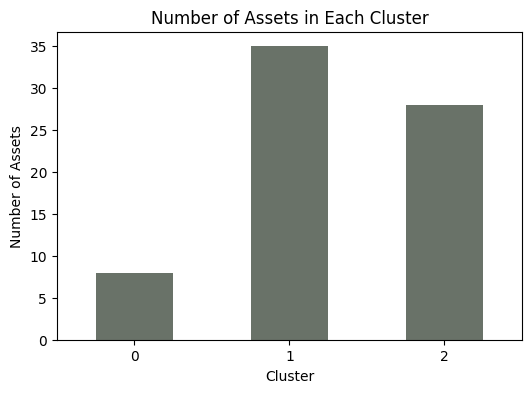

In [88]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = assets_clusters.value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()